# This notebook is concerned with handling Item Name

# Table of contents
- [Overview](#overview)
    - [We'll be dealing with](#well-be-dealing-with)
    - [Approach](#approach)
- [Setup and load data](#setup-and-load-data)
- [Handling Item Names](#Handling-Item-Names)
    - [Normalization and lemmatization](#normalization-and-lemmatization)
        - [Character level normalization](#character-level-normalization)
        - [🚨 Word level normalization and lemmatization](#word-level-normalization-and-lemmatization)
        - [Normalized and Disjointed cols created](#normalized-and-disjointed-cols-created)
    - [Arabic lexicon](#string-tokens)
        - [Create lexicon](#create-lexicon)
        - [Analyze lexicons' word frequency](#analyze-lexicons-word-frequency)
        - [Manual cleaning of edge cases in lexicon](#manual-cleaning-of-edge-cases-in-lexicon)
    - [Combine disjointed letters](#combine-disjointed-letters)
        - [Research findings](#Research-findings)
        - [🚨 ***Trie and Viterbi Segment technique***](#Trie-and-Viterbi-segment-technique)
            - [Algorithm](#algorithm)
                - [Notes (the key decisions in implementing the algorithm)](#Notes-(the-key-decisions-in-implementing-the-algorithm))
                - [A few tests](#a-few-tests)
        - [Rejoining the disjointed letters](#Rejoining-the-disjointed-letters)
            - [Rejoined column created](#rejoined-column-created)
            - [Combined column created](#combined-column-created)
    - [Analyze tokens](#Analyze-tokens)
        - [Token lengths](#token-lengths)
        - [Clean Combined Column](#clean-combined-column)
        - [🚨 Analyzing unknowns in the dataset](#analyzing-unknowns-in-the-dataset)
        - [Before and after preprocessing](#before-and-after-processing)
        - [Save preprocessed Item Name](#save-preprocessed-item-name)
- [🚨 Embed tokens](#embed-tokens)
    - [Requires wiki.ar.align.vec and wiki.en.align.vec in assets but not provided](#requires-wikiaralignvec-and-wikienalignvec-in-assets-but-not-provided)
        - [Compare current vocab with FastText's](#compare-current-vocab-with-fasttexts)
        - [🚨 Interpretable column created](#interpretable-column-created)
        - [Created wiki.trimmed.align.vec](#creating-wikitrimmedalignvec)
        - [Save and load final preprocessed Item Names](#save-and-load-final-preprocessed-item-names)
    - [🚨 Overall look at the state of the data](#overall-look-at-the-state-of-the-data)
    - [Creating wiki.trimmed.align.vec](#creating-wikitrimmedalignvec)
- [Appendix](#Appendix)
    - [Tests - preprocessing](#tests---preprocessing)

# Overview


## We'll be dealing with: 


- Normalizing a mix of Arabic and English entries
- Item codes/numerical values (non descriptive)
- Misplellings and disjointed letters
- Embedding mixed language entries

## Approach:


1. Normalization and lemmatization
    - normalize characters
    - Remove unnecessary chars/symbols/units/fillers
    - lemmatization
    - break corpus into string tokens
3. Generate Arabic lexicon from whole words
    - Calculate unigram probability + Laplace Smoothing 
4. Combine disjointed letters into full words based on the lexicon
    - Trie (data structure) + Viterbi Segment technique (dynamic programming)
5. Analyze tokens in the data
    - Modify preprocessing or apply manual preprocessing if necessary
6. Embed preprocessed Item Names
    - Need to use an embedder capable of handling AR and EN
    - Two options: SBERT - no context in corpus ; skip, FastText aligned wiki vecs for EN and AR
    - Trim the large FastText vecs for our case (>3M tokens combined, >8 GB combined) -> wiki.trimmed.align.vec (1865 tokens, 5 MB)

# Setup and load data

In [ ]:
# Import relevant libraries
import pandas as pd
import matplotlib.ticker as ticker

from math import log

from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants: أ إ آ -> ا
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar,    # ة -> ه or keep ة depending on needs
    normalize_unicode            # Normalize Unicode strings into their canonically composed form
)
from camel_tools.utils.dediac import dediac_ar
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

import re
import unicodedata
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import gensim

In [85]:
data_path = "../data/checkpoints/cleaned_num.xlsx"
df_original = pd.read_excel(data_path)
df = df_original.copy()

# For now we just care about Item Name
df = df[['Item Name']]

# Handling Item Names

## Normalization and lemmatization
Using CAMeL-Tools since it handles Arabic well and compatible with English texts

### Character level normalization

In [86]:
_EXTRA_TRANSLATE = {
    ord('ی'): ord('ي'),   # Farsi Yeh → Arabic Yeh
    ord('ـ'): None,       # Tatweel (kashida) → remove
}

def normalize_text(text: str) -> str:
    # Stronger Unicode compat normalization
    text = unicodedata.normalize('NFKC', text)

    # Existing CAMeL steps
    text = text.lower()
    text = normalize_unicode(text)
    text = dediac_ar(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = text.translate(_EXTRA_TRANSLATE)

    return text.strip()


In [87]:
# Let's see the results - yes I noticed some entries are split (like 1563) which really gave me a headache trying to solve lol
df.iloc[[439, 743, 901, 1563]]

,Item Name
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر
743,كيس مادة
901,GATE BARIAR PANEL2
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ


### Word level normalization and lemmatization

In [88]:
# Cell for lists of dimension/units, protected words, and AR stop words
# List 1: English unit tokens (lowercase; include singular/plural + common abbrevs)
UNIT_TOKENS_EN = {
    "x",
    # length
    "mm","millimeter","millimeters","millimetre","millimetres",
    "cm","centimeter","centimeters","centimetre","centimetres",
    "m","meter","meters","metre","metres", "mtr", "unit",
    "km","kilometer","kilometers","kilometre","kilometres",
    "in","inch","inches",
    "ft","foot","feet",
    "yd","yard","yards",
    "mi","mile","miles",
    # mass
    "g","gram","grams","gramme","grammes",
    "mg","milligram","milligrams","milligramme","milligrammes",
    "kg","kilogram","kilograms","kilogramme","kilogrammes",
    "t","ton","tons","tonne","tonnes",
    "oz","ounce","ounces",
    "lb","lbs","pound","pounds","st","stone","stones",
    # volume
    "l","liter","liters","litre","litres",
    "ml","milliliter","milliliters","millilitre","millilitres",
    "cl","centiliter","centiliters","centilitre","centilitres",
    "dl","deciliter","deciliters","decilitre","decilitres",
    "cc"
}

# List 2: Arabic unit tokens (normalized, no spaces)
UNIT_TOKENS_AR = {
    # length
    "مم","ملم","مليمتر","مليمترات","ملليمتر","ملليمترات",
    "سم","سنتمتر","سنتيمتر","سنتيمترات","سنتمترات",
    "م","متر","أمتار", "مت"
    "كم","كلم","كيلومتر","كيلومترات",
    "إنش","انش","بوصة","بوصات",
    "قدم","أقدام",
    "ياردة","ياردات",
    "ميل","أميال",
    # mass
    "غ","جم","جرام","جرامات","غرام","غرامات",
    "ملغ","مغ","مجم","ميليغرام","ميليجرام","ميليغرامات","ميليجرامات","مليغرام","مليجرام",
    "كغ","كجم","كيلوغرام","كيلوجرام","كيلوغرامات","كيلوجرامات","كيلو",
    "طن","أطنان",
    "أونصة","أونصات","اوقية","أوقية","أوقيات",
    "رطل","أرطال",
    # volume
    "لتر","لترات",
    "ملي","مل","ميليلتر","مليلتر","ميليلترات","مليلترات",
    "سنتيلتر","سنتيلترات","ديسيلتر","ديسيلترات",
    # keywords
    'مقاس', 'سماكه', 'طول'
}
UNIT_TOKENS_AR = [normalize_text(t) for t in UNIT_TOKENS_AR]

protected_words = ["سابك"]

with open('../assets/AR_stop_words.txt', encoding='utf-8') as f:
    AR_STOP = set(normalize_text(line.strip()) for line in f if line.strip())

In [89]:
# Disambiguator and Morphological Tokenizer modules from CAMel-Tools to help with normalizion and lemmatization
mle = MLEDisambiguator.pretrained('calima-msa-r13')
tokenizer = MorphologicalTokenizer(disambiguator=mle, scheme='d3tok', split=True, diac=False)

In [90]:
# Now we'll normalize the text further to ensure we only have Arabic and English characters

def is_arabic_char(c: str) -> bool:
    return '\u0600' <= c <= '\u06FF'

def is_english_char(c: str) -> bool:
    return c.isascii() and c.isalpha()

def keep_arabic_english_only(c: str) -> str:
    if (is_arabic_char(c) or is_english_char(c)) and not c.isdigit():
        return c
    return " "  # replace everything else with space

def preprocess_text(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)
    
    # 3) Split on whitespace
    tokens = text.split()

    # 4) Extra cleaning steps for lexicon
    if no_disjointed:
        # 4.1) Remove dimensions/units/fillers for lexicon
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and \
                   t not in UNIT_TOKENS_AR and t not in AR_STOP and t not in ENGLISH_STOP_WORDS]
    
        # 4.2) Lemmatize and remove clitics for lexicon
        tokens = [t if t in protected_words else ''.join(normalize_text(p) for p in tokenizer.tokenize([t]) if '+' not in p) 
          for t in tokens]
    
        # 4.3) Drop single-letter tokens, and deduplicate within the row for lexicon
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        seen = set()
        tokens = [t for t in tokens if not (t in seen or seen.add(t))]
        return ' '.join(tokens)
    
    # 5) Or retain only the disjointed letters to glue back later
    else:
        tokens = [t for t in tokens if len(t) == 1]
        return ''.join(tokens)

In [190]:
# Some tests to see the results of normalization
text_test1 = "سماكه حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات with"
print("Before normalization:", text_test1)
print("After normalization:", preprocess_text(text_test1))

print("-----------------")

text_test2 = "ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ"
print("Disjoint - before:", text_test2)
print("Disjoint - after:", preprocess_text(text_test2, no_disjointed=False))

Before normalization: سماكه حديد تسليح مجدول السعودي سابك 12 مم * 12 م المخططات with
After normalization: حديد تسليح مجدول سعودي سابك مخططات
-----------------
Disjoint - before: ﺣ ﺪ ﻳ ﺪ ﻣ ﺠ ﺪ ﻭ ﻝ ﺳ ﺎ ﺑ ﻚ 12 ﻣ ﻠ ﻢ * 12 ﻣ ﺘ ﺮ - ﺳ ﻌ ﻮ ﺩ ﻱ
Disjoint - after: 


#### Normalized and Disjointed cols created

In [92]:
df["Normalized"] = '' # Default to ''
df["Normalized"] = (df["Item Name"].apply(preprocess_text, no_disjointed=True)).str.strip()

# Disjointed cols is only concerned with Arabic rows where the normalization wasn't fruitful (i.e. disjointed letters)
df["Disjointed"] = ''
mask = (df["Normalized"] == '') & ~df["Item Name"].apply(lambda s: all(is_english_char(c) for c in str(s) if c.isalpha()))
df.loc[mask, "Disjointed"] = df.loc[mask, "Item Name"].apply(
    preprocess_text, no_disjointed=False 
).str.strip()

In [93]:
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,
743,كيس مادة,كيس ماده,
901,GATE BARIAR PANEL2,gate bariar panel,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,,صاجاسودملمت


Good, now we have normalized Arabic and English words, but also the disjointed chars are saved for later

## Arabic lexicon

### Create lexicon

In [94]:
corpus = df['Normalized']
tokens = [simple_word_tokenize(text) for text in corpus]

In [95]:
len(tokens)

3150

In [96]:
# Lexicon is in Arabic, so we'll remove english for now
def is_arabic(token):
    return bool(re.search(r'[\u0600-\u06FF]', token))

arabic_tokens = [tok for row in tokens for tok in row if is_arabic(tok)]
lexicon = Counter(arabic_tokens)

In [97]:
# How many words did we get?
lexicon.__len__()

646

In [98]:
# Let's quickly check the most frequent words used
lexicon.most_common(20)

[('حديد', 564),
 ('تسليح', 316),
 ('سابك', 212),
 ('اسود', 142),
 ('صاج', 126),
 ('اتفاق', 90),
 ('ماسوره', 73),
 ('وطني', 58),
 ('سلك', 54),
 ('سعودي', 53),
 ('توريد', 46),
 ('مجدول', 40),
 ('راجحي', 38),
 ('ويل', 33),
 ('كيبل', 32),
 ('سويدي', 29),
 ('مسحوب', 25),
 ('مجلفن', 25),
 ('املس', 21),
 ('الواح', 20)]

### Analyze lexicons' word frequency

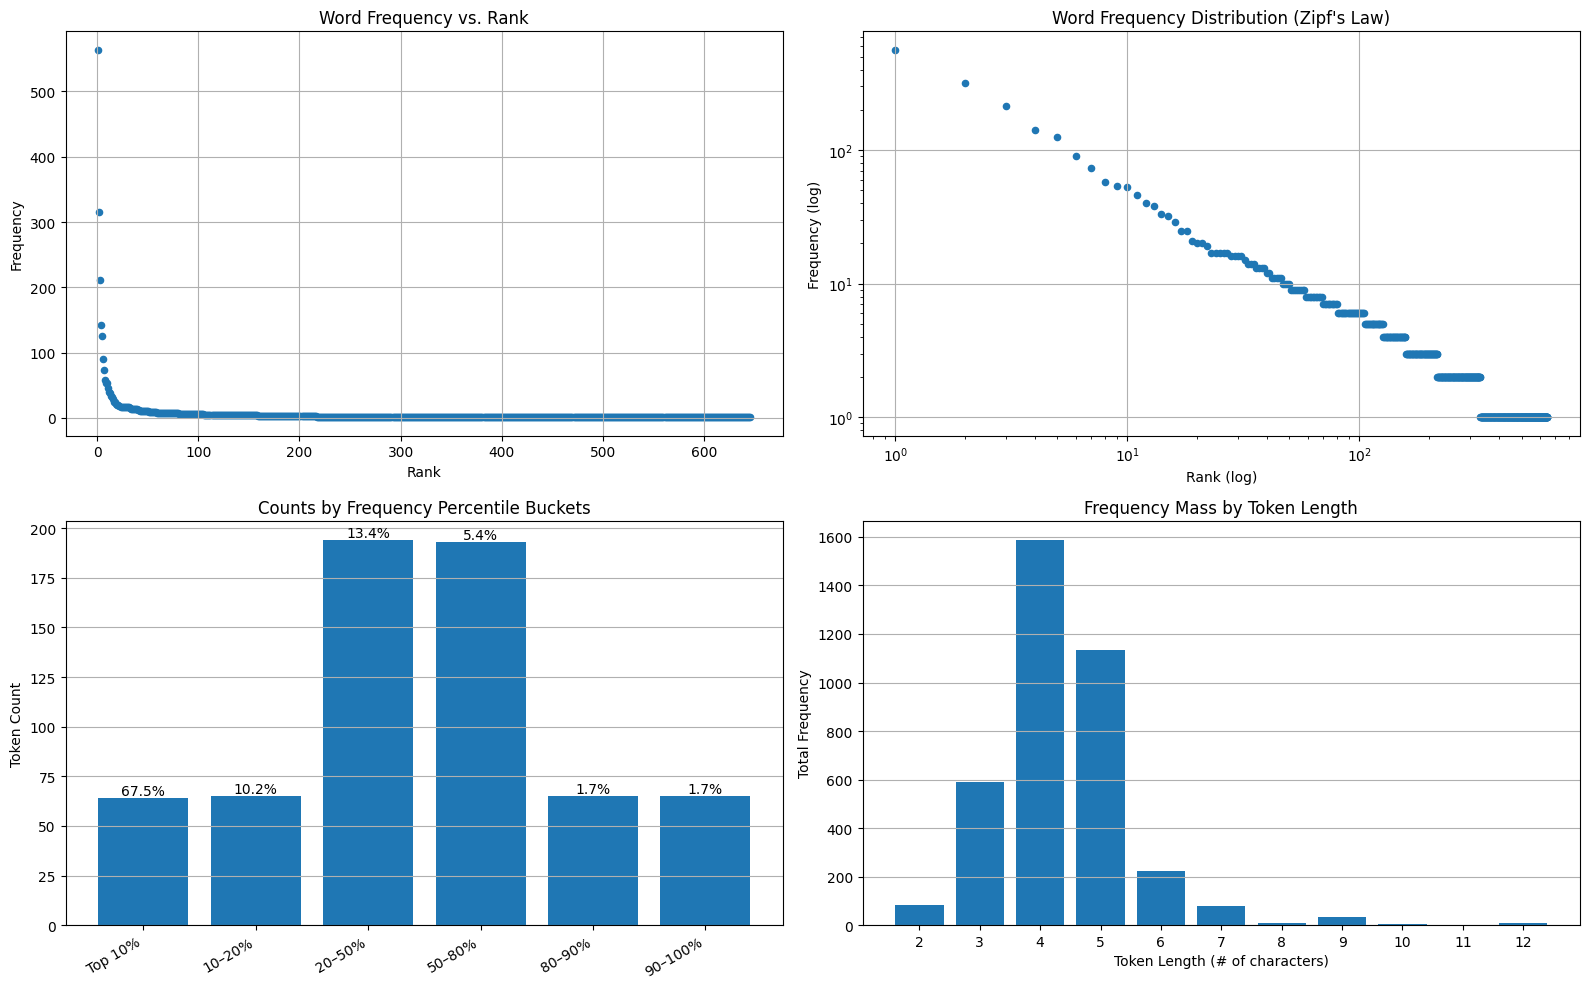

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Sort frequencies descending
freqs_sorted = np.array(sorted(lexicon.values(), reverse=True))
ranks = np.arange(1, len(freqs_sorted) + 1)

# -- precompute percentile buckets (by rank)
N = len(freqs_sorted)
pct_edges = [0, 10, 20, 50, 80, 90, 100]  # buckets: Top10, 10–20, 20–50, 50–80, 80–90, 90–100 (tail)
idx_edges = [int(np.floor(p/100 * N)) for p in pct_edges]
labels = [f"Top {pct_edges[1]}%"] + [f"{pct_edges[i]}–{pct_edges[i+1]}%" for i in range(1, len(pct_edges)-1)]

bucket_counts = []
bucket_mass_share = []
total_mass = freqs_sorted.sum()
for i in range(len(idx_edges)-1):
    lo, hi = idx_edges[i], idx_edges[i+1]
    cnt = max(hi - lo, 0)
    bucket_counts.append(cnt)
    mass = freqs_sorted[lo:hi].sum() if cnt > 0 else 0
    bucket_mass_share.append(100.0 * mass / total_mass if total_mass > 0 else 0.0)

# --- length histogram (1-char, 2-char, 3-char, ...) weighted by frequency
length_mass = {}
for token, c in lexicon.items():
    L = len(token)
    length_mass[L] = length_mass.get(L, 0) + c
lengths = np.array(sorted(length_mass.keys()))
length_counts = np.array([length_mass[L] for L in lengths])

# ---- 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) Simple scatter plot (rank vs frequency)
axes[0, 0].scatter(ranks, freqs_sorted, s=20)
axes[0, 0].set_xlabel("Rank")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Word Frequency vs. Rank")
axes[0, 0].grid(True)

# 2) Zipf's Law (log-log)
axes[0, 1].scatter(ranks, freqs_sorted, s=20)
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel("Rank (log)")
axes[0, 1].set_ylabel("Frequency (log)")
axes[0, 1].set_title("Word Frequency Distribution (Zipf's Law)")
axes[0, 1].grid(True)

# 3) Percentile bucket counts
x = np.arange(len(labels))
axes[1, 0].bar(x, bucket_counts)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(labels, rotation=30, ha="right")
axes[1, 0].set_ylabel("Token Count")
axes[1, 0].set_title("Counts by Frequency Percentile Buckets")
axes[1, 0].grid(True, axis="y")
# annotate each bar with its mass share
for i, (xc, cnt, mass_pct) in enumerate(zip(x, bucket_counts, bucket_mass_share)):
    if cnt > 0:
        axes[1, 0].text(xc, cnt, f"{mass_pct:.1f}%", ha="center", va="bottom")

# 4) Length histogram (frequency-weighted)
axes[1, 1].bar(lengths, length_counts, width=0.8)
axes[1, 1].set_xticks(lengths)
axes[1, 1].set_xlabel("Token Length (# of characters)")
axes[1, 1].set_ylabel("Total Frequency")
axes[1, 1].set_title("Frequency Mass by Token Length")
axes[1, 1].grid(True, axis="y")

plt.tight_layout()
plt.show()


#### **Plots 1 & 2**

This might be an extreme case of Zipf's law, but the frequency of the word is strongly inversely related to its rank

Nonetheless, when reconstructing the words from the disjoint words, we'll ensure that we give more frequent words more weight, sort of a probabilistic approach. The priors being the frequency of the term in the lexicon relative to the other terms.

#### **Plot 3**

The top 10% most frequent tokens appear in 67.6% of the normalized corpus. Whereas the bottom 30% tokens appear in less than 10% of the corpus. To be cautious but also remove things that are less frequent, we'll remove the buttome 10% of tokens. 

In [100]:
# Just to be sure let's see some of those buttom 10%
items_sorted = sorted(lexicon.items(), key=lambda x: x[1])  
N = len(items_sorted)

# Bottom 10% by rank
pct = 10
cutoff_idx = min(int(np.ceil(pct / 100 * N)), 15)
bottom_10 = items_sorted[:cutoff_idx]

print(f"Bottom {pct}% tokens by rank (capped at 15 tokens):")
for token, freq in bottom_10:
    print(f"{token}: {freq}")

Bottom 10% tokens by rank (capped at 15 tokens):
مبسط: 1
برونزالفاء: 1
اماراتي: 1
هان: 1
رويال: 1
حليب: 1
سوبر: 1
سمارت: 1
ريمون: 1
موديل: 1
برنزالفاء: 1
سيليكون: 1
اكر: 1
طبشه: 1
درفه: 1


The words appear to be meaningful, so we'll not drop any.

#### **Plot 4**

Most words fall within 3 and 7 characters. Let's see some examples of the extremes at 2 chars and >=9 chars long:

In [101]:
{k: v for k, v in lexicon.items() if len(k) == 2}

{'رش': 4,
 'شب': 9,
 'دن': 1,
 'حر': 11,
 'سد': 8,
 'اي': 5,
 'لب': 3,
 'خط': 1,
 'حب': 1,
 'كل': 1,
 'يا': 1,
 'ات': 11,
 'تر': 1,
 'جد': 3,
 'يد': 2,
 'ين': 1,
 'نص': 1,
 'يخ': 5,
 'جي': 1,
 'دي': 2,
 'شر': 1,
 'ال': 1,
 'خا': 1,
 'قص': 5,
 'سن': 1,
 'صب': 1,
 'مت': 2}

In [102]:
{k: v for k, v in lexicon.items() if len(k) >= 9}

{'برونزالفاء': 1,
 'برنزالفاء': 1,
 'المستعماره': 2,
 'بوصهبلاستيك': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'الابعادpanel': 8,
 'والقسامات': 1,
 'واالكسسوارات': 1,
 'ايزوبروبيل': 1,
 'حديدتسليح': 4,
 'استتواريو': 1}

There is a mix between words that are uninterpretable and ones that are not. Unfortunately this may be a byproduct of the CAMel-tools tokenizer-disambiguator combo, which was our only efficient hope of normalizing and lemmatizing the tokens. Hence, this approach will suffice for now. More efforts could be shed on improving the normalization phase so we can further optimize the lexicon.

**Note:** I'll manually clean these tokens to improve our lexicon.

### Manual cleaning of edge cases in lexicon

In [103]:
# Extract and remove tokens surgically
extract_map = {
    'الابعادpanel': ['الابعاد', 'panel'],
    'بوصهبلاستيك': ['بلاستيك'],
    'واالكسسوارات': ['اكسسوارات'],
    'برونزالفاء': ['برونز'],
    'برنزالفاء': ['برونز'],
    'والقسامات': ['قسامات'],
    'حديدتسليح': ['حديد','تسليح'],
}

# Apply extractions
for src, parts in extract_map.items():
    if src in lexicon:
        for p in parts:
            p = preprocess_text(p)
            if p in lexicon:
                lexicon[p] += 1
            else:
                lexicon[p] = 1
        lexicon.pop(src, None)

remove_words = {
    'شب','دن','حر','اي','لب','حب','كل','يا','ات','تر','جد','يد','ين','يخ','جي','دي','شر','ال','خا','سن','مت', 'نص',
    'استتواريو', 'المستعماره'
}

for bad in remove_words:
    lexicon.pop(bad, None)

{k: v for k, v in lexicon.items() if len(k) >= 9 or len(k) == 2}

{'رش': 4,
 'سد': 8,
 'اكسسوارات': 9,
 'الخرسانيه': 17,
 'خط': 1,
 'ايزوبروبيل': 1,
 'قص': 5,
 'صب': 1}

In [104]:
lexicon.get(preprocess_text("الابعاد"))

9

In [105]:
# Let's not forget to clean the normalized column based on our manual work above

# 1) Build replacement strings from extract_map
replacement_map = {k: " ".join(v).strip() for k, v in extract_map.items()}

# 2) Compile regex to catch keys, sorted by length to avoid partial collisions
keys = sorted(replacement_map.keys(), key=len, reverse=True)
pattern = re.compile("|".join(map(re.escape, keys)))

# 3) Set of removable words
remove_words_set = set(remove_words)

def normalize_text(s):
    if not isinstance(s, str):
        return s
    
    # --- substring replacements ---
    out = pattern.sub(lambda m: replacement_map[m.group(0)], s)
    
    # --- word removals ---
    tokens = out.split()
    kept = [t for t in tokens if t not in remove_words_set]
    
    if not kept:  # everything removed
        return "unknown"
    
    # --- finalize ---
    out = " ".join(kept)
    out = re.sub(r"\s+", " ", out).strip()
    return out

df["Normalized"] = df["Normalized"].apply(normalize_text)

## Combine disjointed letters
Combining the letters based on the lexicon is only one half of the solution, the harder part is understanding the boundaries of words where letters are disjointed and ambiguous.

### Research findings


This problem could be cut in three parts:
1. Find unigram probability for each lexicon entry
    - We don't have a large enough corpus to use ngrams, plus we don't know the boundaries of words
2. Create a Trie data structure from the lexicon
3. Traverse the Trie and determine the word with most likelihood
    - We could go about the traversal using a greedy approach, which means looking at each word in the sentence alone, but I've decided to follow a better approach (Viterbi algo.) which looks at how the words fit in a sentance

### ***Trie and Viterbi Segment technique***

#### Algorithm

In [106]:
# Node definition for the Trie
class TrieNode: 
    __slots__ = ("ch","end","logp")
    def __init__(self):
        self.ch = {} # Children nodes dictionary
        self.end = False # Boolean: node marks a word's end
        self.logp = float("-inf") # Likelihood for this word, only relevant if end is True 

# Trie structure to hold the lexicon
class Trie:
    def __init__(self):
        self.root = TrieNode()
    def insert(self, word, logp): # Insert a node in the Trie
        node = self.root
        for c in word:
            node = node.ch.setdefault(c, TrieNode()) # If there's a node for c return it, else create a new node for c
        node.end = True
        node.logp = logp
    def in_trie_prefix(self, s): # Checks if the string/word is in our Trie
        node = self.root
        for ch in s:
            if ch not in node.ch:
                return False
            node = node.ch[ch]
        return node.end

# The blueprint to creating the Trie DS
def build_trie_from_counts(counts, alpha=0.0):
    # counts: dict[word] -> int
    V = len(counts) # Vocabulary size
    Z = sum(counts.values()) + alpha * V # Denominator = N_train (total no. of words) + weighted V
    T = Trie()
    for w, c in counts.items():
        p = (c + alpha) / Z
        T.insert(w, log(p))
    return T

def viterbi_segment(chars, trie, del_char_logp=log(6.7e-3)): # ≈ -5.00
    """chars: e.g. 'catsanddog' (spaces removed). Returns words and score."""

    if chars == "":
        return "", 1
    
    n = len(chars)
    best = [float("-inf")] * (n + 1)
    back = [None] * (n + 1) # (end of word index for word starting at i: int, start of a word: boolean)
    best[n] = 0.0  # empty suffix has score 0

    # This loop begins at the end of the sentence, to evaluate all possible word formations taking into account the entire sentence
    for i in range(n - 1, -1, -1): 
        node = trie.root
        j = i
        while j < n and chars[j] in node.ch: # Check if the char exists in the children of the current node
            node = node.ch[chars[j]] # Look at the branch associated with chars[j]
            j += 1
            if node.end: # If chars[i:j] completes a word, then step in
                cand = node.logp + best[j] # The core of the Viterbi DP; considers likelihood of chars[i:j] and even chars[j:] 
                if cand > best[i]:
                    best[i] = cand
                    back[i] = (j, True)
        
        # Mark char position as a skip when it doesn't form a word and propagate logp.
        # This helps when the end of the sentence isn't found in lexicon/Trie.
        # The del_char_logp is added to penalize skipping characters
        cand_skip = best[i+1] + del_char_logp  
        if cand_skip > best[i]:
            best[i] = cand_skip
            back[i] = (i+1, False)

    # Reconstruct the words
    words = []
    i = 0
    while i < n:
        j, is_word = back[i]
        if is_word: # i.e. character at i isn't marked as skip
            words.append(chars[i:j])
        i = j

    
    
    if len(words) == 1: # Sometimes we'll only recognize one word; let's flag the case with 1
        return words, 1
    
    elif not words: # In case we failed to construct any words; flag with 0
        return "unknown", 0
    
    else: # We found a list of words; return the score (<0) and join by space later to reconstruct sentence
        return words, best[0]

##### Notes (the key decisions in implementing the algorithm)


- **Scoring**
  
  - Use natural-log probabilities: `node.logp = log p(w) ≤ 0`.  
  - Base case: `best[n] = 0.0` (log 1). A fallback case when no words are found.

- **Transitions at position i**
  
  - **Words:** for each trie end at `j`, candidate = `node.logp + best[j]`.  
  - **Skip 1 char:** candidate = `best[i+1] + del_char_logp`. Always include it as a competitor (not just a fallback).

- **Skip penalty**
  
  - Set `del_char_logp = log(p_del)` with `0 < p_del << 1` (same log base).  
  - Example: `del_char_logp = log(6.7e-3) ≈ -5.0`.  

- **Decision intuition (per-char threshold)**
  
  - Word of length `L` beats skipping those `L` chars iff  
    `log P(w) > L * del_char_logp` ⇔ `(log P(w))/L > del_char_logp`.  
  - So `del_char_logp` acts as a per-character quality threshold.

- **Correction to earlier intuition**
  
  - Choosing a word at `[i:j)` does **not** force later scores below `best[j+1]`.  
  - With a **negative** skip penalty, a strong word can outperform a run of skips by avoiding `L * |del_char_logp|`.

- **Bias toward frequent words**
  
  - Already handled by larger (less negative) `log P(w)`.  
  - Tune `del_char_logp` to trade off segmentation vs. deletions; already tried multiple hyperparamters.

##### A few tests


In [107]:
# Toy example
counts = {
    "cat": 40, "cats": 30, "sand": 5, "and": 20, "an": 25, "dog": 70
}
trie = build_trie_from_counts(counts, alpha=1.0)
words, score = viterbi_segment("catsanddogfiller", trie)
print(words)  # e.g., ['cats', 'and', 'dog'] 


['cats', 'and', 'dog']


In [108]:
# Examples from our data

trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[1563], trie_ar)
print(df["Disjointed"].iloc[1563])
print(words, score)

صاجاسودملمت
['صاج', 'اسود'] -26.945972962459084


In [109]:
trie_ar = build_trie_from_counts(lexicon, alpha=1.0)
words, score = viterbi_segment(df["Disjointed"].iloc[2833], trie_ar)
print(df["Disjointed"].iloc[2833])
print(words, score)

حديدمجدولاتفاقملممترسعود
['حديد', 'مجدول', 'اتفاق'] -60.58907237768291


In [110]:
print("سماكه in trie?", trie_ar.in_trie_prefix("سماكه"))

سماكه in trie? False


In [111]:
print("مجدول in trie?", trie_ar.in_trie_prefix("مجدول"))

مجدول in trie? True


### Rejoining the disjointed letters
Now we can reconstruct the disjointed letters in the Item Name column

In [112]:
def segment_and_join(text, trie):
    words, score = viterbi_segment(text, trie)
    
    # Catch edge cases
    if score == 0 or score == 1:
        return words
    
    # Join words with spaces
    else: 
        return " ".join(words)

#### Rejoined column created

In [113]:
df["Rejoined"] = ''
df["Rejoined"] = (df["Disjointed"].apply(lambda t: segment_and_join(t, trie_ar))).str.strip()

In [114]:
# Let's see the results
df.iloc[[439, 743, 901, 1563]]

,Item Name,Normalized,Disjointed,Rejoined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,,
743,كيس مادة,كيس ماده,,
901,GATE BARIAR PANEL2,gate bariar panel,,
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,unknown,صاجاسودملمت,صاج اسود


In [115]:
df["Rejoined"].iloc[2833]

'حديد مجدول اتفاق'

#### Combined column created

In [116]:
# Now let's add a new fully preprocessed column, when there are rejoined chars add that, else resort to Combined
df["Combined"] = (
    df["Rejoined"].fillna("").str.strip()
    .where(df["Rejoined"].fillna("").str.strip() != "", df["Normalized"].fillna("").str.strip())
)
df.iloc[[439, 743, 901, 1563, 1663]]

,Item Name,Normalized,Disjointed,Rejoined,Combined
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,,,تيوب المنيوم مستطيل
743,كيس مادة,كيس ماده,,,كيس ماده
901,GATE BARIAR PANEL2,gate bariar panel,,,gate bariar panel
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,unknown,صاجاسودملمت,صاج اسود,صاج اسود
1663,XT1N 160 TMD 40-450 3p F F,xt tmd,,,xt tmd


In [117]:
df_test = df[df["Disjointed"] != ""]
df_test.to_excel("../data/analyze/reconstructed_entries.xlsx", index=False)
df_test.head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined
1562,ﺻ ﺎ ﺝ ﺍ ﺳ و د 1220 * 2440 * 20 ﻣ ﻠ,unknown,صاجاسودمل,صاج اسود,صاج اسود
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,unknown,صاجاسودملمت,صاج اسود,صاج اسود
1565,ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 5 ﺑ و ﺻ ﺔ * 4.0 ﻣ ﻝ 12 ﻣ ﺗ ﺭ,unknown,ماسورهاسودبوصهملمتر,ماسوره اسود,ماسوره اسود
1566,ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 5 ﺑ و ﺻ ﺔ * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ,unknown,ماسورهاسودبوصهملمتر,ماسوره اسود,ماسوره اسود
1567,ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ,unknown,تيوبفارغمربعملمتر,تيوب فارغ مربع,تيوب فارغ مربع


## Analyze tokens

### Token lengths

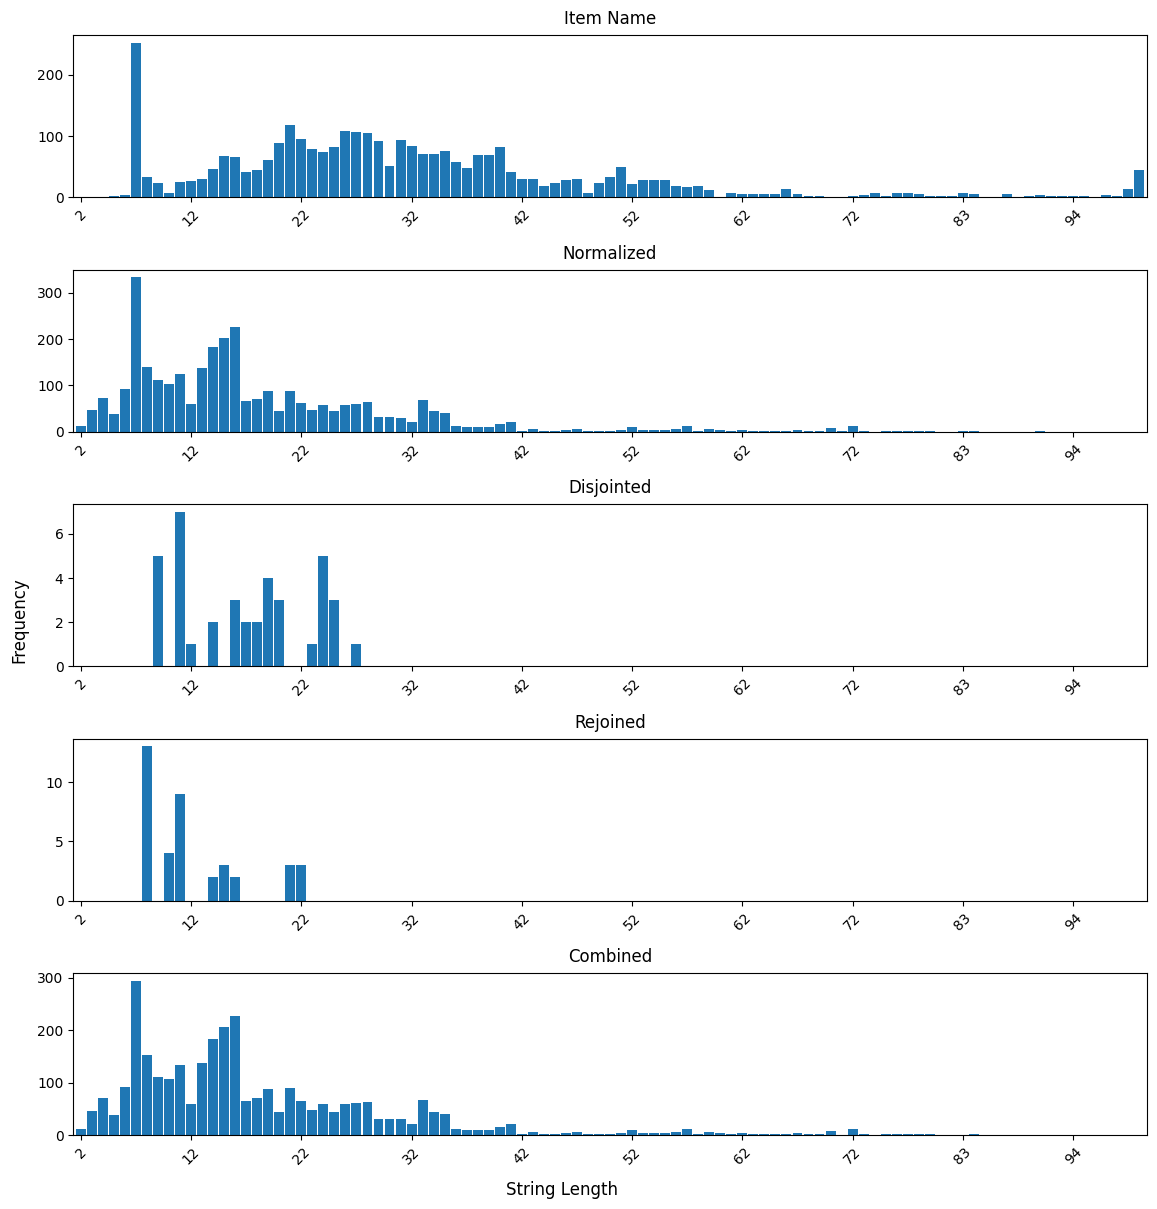

In [118]:
# Visualize the character lengths per preprocessing stage

# Columns where zero-length is an artifact you'd like to ignore
drop_zero_len_cols = {"Disjointed", "Rejoined"}

length_counts = {}
for col in df.columns:
    lengths = df[col].astype(str).str.len()
    if col in drop_zero_len_cols:
        lengths = lengths[lengths > 0]  # drop zeros only for these columns
    length_counts[col] = lengths.value_counts().sort_index()

# Put into a DataFrame (rows = lengths, columns = original columns)
length_counts_df = pd.DataFrame(length_counts).fillna(0).astype(int)

# Plot histograms per column with cleaner style
fig, axes = plt.subplots(len(length_counts_df.columns), 1, figsize=(12, 2.5*len(length_counts_df.columns)), sharex=False)

for ax, col in zip(axes, length_counts_df.columns):
    length_counts_df[col].plot(kind="bar", ax=ax, width=0.9)
    ax.set_title(col, fontsize=12, pad=8)
    
    # Show only ticks at 0, 10, 20, ... up to 100
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Rotate x labels for readability
    ax.tick_params(axis="x", rotation=45)

# Global x label
fig.text(0.5, 0.04, "String Length", ha="center", fontsize=12)
fig.text(0.04, 0.5, "Frequency", va="center", rotation="vertical", fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.show()

In [119]:
df[df["Combined"] == ""].head(5)

,Item Name,Normalized,Disjointed,Rejoined,Combined


After normalization many of the original Item Names shrunk down as a result of removing digits, untis, and so on. 

Disjointed and Rejoined also exhibit a similar trend. To clear something first, the plot shows only the rows where there were values (disjoint letters). Overall, the sentence legnths shrunk due to some words found in the respective rows not being present in the lexicon. However, we can clearly see that no rows were completely eliminated; we successfully brought back some context from the disjoint letters.

Lastly, the combined letters match the distribution of the normalized column. This is normal as we only added 39 rows from Rejoined, and that didn't change the distrubution by much.

All in all. Most rows have at least a few characters/words that we could extract the context of the purchase from. Notably, there are some rows in Combined with <= 2 which are mostly English entries (e.g., S201-C10) where digits and symbols were removed and letters were left disjoint. We'll work on cleaning these now.

### Clean Combined column

#### Entries with <= 2 chars

In [120]:
# Let's see the combined Item Names with <= 2 chars
df[df["Combined"].str.len() <= 2]

,Item Name,Normalized,Disjointed,Rejoined,Combined
1497,DP 25CM*40CM*2M D20,dp,,,dp
1498,DP 30CM*40CM*2M D20,dp,,,dp
1499,DP 25CM*40CM*40CM D20,dp,,,dp
1659,GI 0.60X1219X2440MM,gi,,,gi
1660,GI 0.80X1219X2440MM,gi,,,gi
1661,GI 1.00X1219X2440MM,gi,,,gi
1662,GI 0.70X1219X2440MM,gi,,,gi
1706,XT6D 800 3p F F,xt,,,xt
1723,XT1D 160 4p F F,xt,,,xt
1730,SH201-C6,sh,,,sh


It appears that some Item Names were recorded only as their common code names. No description provided about what the product is. For such cases I'll manually populate `Combined` with the code names for these entries. We can see that the first word in Item Name effectively captures most of the knowledge we could get of each item.

In [121]:
# Assign first word of "Item Name" where mask is True
mask = df["Combined"].astype(str).str.len() <= 2
df.loc[mask, "Combined"] = df.loc[mask, "Item Name"].str.split().str[0].str.lower()

In [122]:
df[mask]

,Item Name,Normalized,Disjointed,Rejoined,Combined
1497,DP 25CM*40CM*2M D20,dp,,,dp
1498,DP 30CM*40CM*2M D20,dp,,,dp
1499,DP 25CM*40CM*40CM D20,dp,,,dp
1659,GI 0.60X1219X2440MM,gi,,,gi
1660,GI 0.80X1219X2440MM,gi,,,gi
1661,GI 1.00X1219X2440MM,gi,,,gi
1662,GI 0.70X1219X2440MM,gi,,,gi
1706,XT6D 800 3p F F,xt,,,xt6d
1723,XT1D 160 4p F F,xt,,,xt1d
1730,SH201-C6,sh,,,sh201-c6


In [123]:
# Let's also replace dp and gi while we're at it with something meaningful:
mask = df["Combined"].astype(str).str.len() <= 2

# Lowercased version for matching
vals = df.loc[mask, "Combined"].str.lower()

df.loc[mask, "Combined"] = (
    vals.replace({
        "dp": "panel",
        "gi": "iron"
    }).fillna(vals)  # keep original if not in mapping
)
df[mask]

,Item Name,Normalized,Disjointed,Rejoined,Combined
1497,DP 25CM*40CM*2M D20,dp,,,panel
1498,DP 30CM*40CM*2M D20,dp,,,panel
1499,DP 25CM*40CM*40CM D20,dp,,,panel
1659,GI 0.60X1219X2440MM,gi,,,iron
1660,GI 0.80X1219X2440MM,gi,,,iron
1661,GI 1.00X1219X2440MM,gi,,,iron
1662,GI 0.70X1219X2440MM,gi,,,iron


Later in categorization, although the embedder maps EN and AR, words like sabic which have no meaning in English and cause unnecessary trouble to get mapped to سابك. Hence, I'll take a manual step here to remedy that.

In [124]:
# Let's also replace dp and gi while we're at it with something meaningful:
mask = df["Combined"].str.contains("sabic", case=False, na=False)

df.loc[mask, "Combined"] = (
    df.loc[mask, "Combined"].str.replace("sabic", "سابك", case=False)
)

df[mask]

,Item Name,Normalized,Disjointed,Rejoined,Combined
362,Reinforcing Steel Bar Sabic 8 mm 6 MTR (Unit: ...,reinforcing steel bar sabic,,,reinforcing steel bar سابك
368,HR Sheet 1.50x1220x2440mm Sabic,hr sheet sabic,,,hr sheet سابك
369,HR Sheet 2.00x1220x3000mm Sabic,hr sheet sabic,,,hr sheet سابك
370,HR Coil 1.50x1000mm Sabic,hr coil sabic,,,hr coil سابك
371,HR Sheet 1.50x1220x3000mm Sabic,hr sheet sabic,,,hr sheet سابك
...,...,...,...,...,...
3131,14.0 mm Black Deformed Straight Bar G60-12 M-S...,black deformed straight bar sabic,,,black deformed straight bar سابك
3132,25.0 mm Black Deformed Straight Bar G60 - 12 M...,black deformed straight bar sabic,,,black deformed straight bar سابك
3133,18.0 mm Black Deformed Straight Bar G60-12 M -...,black deformed straight bar sabic,,,black deformed straight bar سابك
3140,32.0 mm Black Deformed Straight Bar G60-12 M-S...,black deformed straight bar sabic,,,black deformed straight bar سابك


### Analyzing unknowns in the dataset

In [125]:
flags = pd.DataFrame({
    "Item Name": (df["Item Name"] == "unknown"),
    "Combined": (df["Combined"] == "unknown"),
    "Normalized": (df["Normalized"] == "unknown"),
})

# Get counts for all combinations
combo_counts = flags.value_counts().sort_index()

# Print them nicely
for (item_unknown, combined_unknown, normalized_unknown), count in combo_counts.items():
    print(
        f"Item Name={'unknown' if item_unknown else 'known'}, "
        f"Normalized={'unknown' if normalized_unknown else 'known'}, "
        f"Combined={'unknown' if combined_unknown else 'known'} "
        
        f"→ {count}"
    )


Item Name=known, Normalized=known, Combined=known → 2848
Item Name=known, Normalized=unknown, Combined=known → 39
Item Name=known, Normalized=unknown, Combined=unknown → 23
Item Name=unknown, Normalized=unknown, Combined=unknown → 240


The only combinations of unknowns are shown above. Here's my commentary:
1. The first combination represents the good entries: we have item names -> normalized well -> combined has good input
2. The second combination represents the disjointed letters: there are 39 total, normalization cleared them -> later rejoined
3. Third combo; these are the ones I'm intrested in now, we had something at the start -> got nothing later
4. Fourth combo represents embty Item Names -> naturally no info at the end
That's it, other combos don't exist in the dataset

In [126]:
subset = df[
    (df["Item Name"] != "unknown") &
    (df["Normalized"] == "unknown") &
    (df["Combined"] == "unknown")
]

print(len(subset))  # should be 23
subset

23


,Item Name,Normalized,Disjointed,Rejoined,Combined
1675,S201-C10,unknown,,,unknown
1676,S203-C6,unknown,,,unknown
1681,S203-C63,unknown,,,unknown
1697,S201-C16,unknown,,,unknown
1698,S202-C10,unknown,,,unknown
1703,S204-C40,unknown,,,unknown
1718,S201-C6,unknown,,,unknown
1719,S202-C10,unknown,,,unknown
1720,S202-C40,unknown,,,unknown
1740,S201-C20,unknown,,,unknown


These are the cases where Item Name is only the code name for the purchased goods. We'll populate the Combined column with them and solve the ambiguity later. Except for entry 2015 - why would they put just dimensions?

In [127]:
mask = (
    (df["Item Name"] != "unknown") &
    (df["Normalized"] == "unknown") &
    (df["Combined"] == "unknown")
)

# Check if Item Name is a single word (no spaces after stripping)
single_word = df.loc[mask, "Item Name"].str.strip().str.split().str.len() == 1

# Update Combined with Item Name for those rows
df.loc[mask & single_word, "Combined"] = df.loc[mask & single_word, "Item Name"].str.lower()

In [128]:
subset = df[
    (df["Item Name"] != "unknown") &
    (df["Normalized"] == "unknown") &
    (df["Combined"] == "unknown")
]

print(len(subset))  # should be 1
subset

1


,Item Name,Normalized,Disjointed,Rejoined,Combined
2015,40 X 40 X 3,unknown,,,unknown


### Before and after processing

In [129]:
# Let's see how many unique rows we've got
print("Number of unique rows before cleaning:", df["Item Name"].nunique())
print("Number of unique rows after cleaning:", df["Combined"].nunique())

print("-------------------------------------")

# Let's see how many unique words we've got
words_before = set(" ".join(df["Item Name"]).split())
words_after = set(" ".join(df["Combined"]).split())

print("Number of unique words before cleaning:", len(words_before))
print("Number of unique words after cleaning:", len(words_after))

Number of unique rows before cleaning: 2303
Number of unique rows after cleaning: 1253
-------------------------------------
Number of unique words before cleaning: 4190
Number of unique words after cleaning: 1922


We've effectively reduced the variablity from entry to entry to 1262 down from 2303. This means we stripped each entry down to its essence, all using efficient and lightweight techniques.

As for the number of unique words, they were reduced to less than half, removing all unnecessary dimensions/units/fillers. This will enable us to look at what makes each entry unique from a larger perspective and move similar entries closer.

### Save preprocessed Item Name

Save the unique words in the preprocessed Item Name as a vocabulary dataset for later reference as an excel file

In [130]:
# split all text in Combined into words
words = " ".join(df["Combined"].astype(str)).split()

# get unique vocab and sort alphabetically
vocabulary = sorted(set(words))

# save to Excel
pd.DataFrame(vocabulary, columns=["Vocabulary"]).to_excel("../data/vocab/vocabulary.xlsx", index=False)

# Embed tokens

During tests of multiple embedding techniques, I found it difficult to arrive at meaningful results that could lead to effective clustering. Two issues were mainly faced:
1. Words could be in AR and EN, yet their embeddings would be farther apart than what they should be
    - SBERT landed pretty good results but didn't overcome the second issue
    - FastText's aligned vectors shine here!
2. Item Names are fragmented, incohesive, contain misspelled words, and after preprocessing & cleaning some context was removed (a step for the better)
    - SBERT and similar transformer based approaches thrive on context, which this dataset lacks. FastText's vecs allow us to look at each word individually, which suits our case better

Now, we're going to look at the tokens we've cleaned, compare them with tokens recognized by FastText. Then we'll do a bit more work to align the last few (~200) tokens not recognized. THEN we'll FINALLY get to embed the words numerically and categorize them.

**NOTE:** FastText offers .bin files that could better approximate the words to their best embeddings. Unfortunately, I've started working with .vecs, and it only offers lookup capabilities. While swithing at this point is feasable, due to time constraints, this is something I'd improve in the future when faced with a similar challenge.

## Requires wiki.ar.align.vec and wiki.en.align.vec in assets but not provided

### Compare current vocab with FastText's

In [131]:
print("""If you want the full aligned vecs which I used at this step, download them from https://fasttext.cc/docs/en/pretrained-vectors.html
Note: they're large, and hence I'll provide a trimmed version in the assets folder that is most relevant to us""")
# ft_ar_aligned = gensim.models.KeyedVectors.load_word2vec_format("../assets/wiki.ar.align.vec", binary=False)
# ft_en_aligned = gensim.models.KeyedVectors.load_word2vec_format("../assets/wiki.en.align.vec", binary=False)

If you want the full aligned vecs which I used at this step, download them from https://fasttext.cc/docs/en/pretrained-vectors.html
Note: they're large, and hence I'll provide a trimmed version in the assets folder that is most relevant to us


In [ ]:
# # Analyze our corpus with respect to the Wiki word vectors (aligned version)  
# ar_counter_aligned = 0
# en_counter_aligned = 0
# unknown = []

# for i in vocabulary:
#     if i in ft_ar_aligned:
#         ar_counter_aligned += 1
#     elif i in ft_en_aligned:
#         en_counter_aligned += 1
#     else:
#         unknown.append(i)

# print("Aligned AR wiki length:", len(ft_ar_aligned))
# print("Aligned EN wiki length:", len(ft_en_aligned))
# print("Our vocabulary's length:", len(vocabulary))
# print("# of words we found in aligned ft_ar dictionary:", ar_counter_aligned)
# print("# of words we found in aligned ft_en dictionary:", en_counter_aligned)
# print("# of words we couldn't find in aligned dicts:", len(unknown))


# if unknown:
#     import pandas as pd
#     pd.DataFrame(unknown, columns=["token"]).to_excel("../data/analyze/unknown_tokens.xlsx", index=False)
#     print("saved to ../data/unkonwn_tokens.xlsx")

print("""  
Result:
Aligned AR wiki length: 610977
Aligned EN wiki length: 2519370
Our vocabulary's length: 1922
# of words we found in aligned ft_ar dictionary: 1494
# of words we found in aligned ft_en dictionary: 218
# of words we couldn't find in aligned dicts: 210
saved to ../data/unkonwn_tokens.xlsx
""")

Aligned AR wiki length: 610977
Aligned EN wiki length: 2519370
Our vocabulary's length: 1922
# of words we found in aligned ft_ar dictionary: 1494
# of words we found in aligned ft_en dictionary: 218
# of words we couldn't find in aligned dicts: 210
saved to ../data/unkonwn_tokens.xlsx


Sweet! Our cleaning and preprocessing stage has paid off immensely. Most words were found in the aligned vectors. We'll now try to recover as many unknown words as possible (out of 210) from the two vecs. Then, we'll have numerically embedded tokens that are meaningful during clustering.

### Interpretable column created

In [ ]:
# # Very long cell; I got the ideas, prompted ChatGPT, and the result is actually outstanding 
# # -----------------------------
# # Output sanitization (letters/spaces only)
# # -----------------------------
# _ONLY_LETTERS_AR_EN_SPACE = re.compile(r"[^A-Za-z\u0600-\u06FF ]+")

# def _sanitize_out(s: str) -> str:
#     s = (s or "").lower()
#     s = _ONLY_LETTERS_AR_EN_SPACE.sub(" ", s)
#     s = re.sub(r"\s+", " ", s).strip()
#     return s

# # -----------------------------
# # Language pick (first character only)
# # -----------------------------
# def _first_char_lang(token: str) -> str:
#     if not token:
#         return "en"
#     c = token[0]
#     if is_arabic_char(c):
#         return "ar"
#     if is_english_char(c):
#         return "en"
#     return "en"

# # -----------------------------
# # Code-name detection (all -> "circuit channel")
# # -----------------------------
# def _is_code_like(token: str) -> bool:
#     t = (token or "").lower()
#     return bool(re.search(r"[a-zA-Z\u0600-\u06FF]+.*\d|^\d", t) or "-" in t)

# def _code_descriptor(_: str) -> str:
#     # Unified, meaningful, number/symbol-free descriptor
#     return "circuit breaker"

# # -----------------------------
# # Candidate generators for vec hits
# # -----------------------------
# _WS = re.compile(r"\s+")
# _KEEP_AR_EN_NUM = re.compile(r"[^a-z0-9\u0600-\u06FF]+")

# def _strip_punct_compact(s: str) -> str:
#     """Keep letters/digits (AR/EN) only and compact."""
#     return _WS.sub("", _KEEP_AR_EN_NUM.sub(" ", (s or "").lower())).strip()

# def _progressive_suffixes(s: str, min_len: int = 3):
#     s = (s or "").lower()
#     for L in range(len(s), min_len - 1, -1):
#         yield s[:L]

# def _progressive_prefixes(s: str, min_len: int = 3):
#     s = (s or "").lower()
#     for start in range(0, max(0, len(s) - min_len + 1)):
#         sub = s[start:]
#         if len(sub) >= min_len:
#             yield sub

# def _sliding_substrings(s: str, max_k: int = 6, min_k: int = 3):
#     s = _strip_punct_compact(s)
#     n = len(s)
#     for k in range(min(max_k, n), min_k - 1, -1):
#         for i in range(0, n - k + 1):
#             yield s[i:i+k]

# def _first_in_vocab(cands: Iterable[str], kv: KeyedVectors) -> str:
#     for c in cands:
#         if c in kv.key_to_index:
#             return c
#     return ""

# # -----------------------------
# # Build token mapping for `unknown`
# # -----------------------------
# def build_token_mapping(
#     unknown: List[str],
#     ft_ar_aligned: KeyedVectors,
#     ft_en_aligned: KeyedVectors,
# ) -> Dict[str, str]:
#     """
#     Map each unknown token to:
#       - 'circuit channel' if it's code-like;
#       - the first vec hit via increasingly loose search (letters/spaces only);
#       - 'unknown' otherwise.
#     """
#     mapping: Dict[str, str] = {}

#     for raw_tok in unknown:
#         tok = (raw_tok or "").strip().lower()
#         if not tok:
#             mapping[tok] = "unknown"
#             continue

#         # 1) Code-like => unified descriptor
#         if _is_code_like(tok):
#             mapping[tok] = _sanitize_out(_code_descriptor(tok)) or "unknown"
#             continue

#         # 2) Choose vec by first character only
#         kv = ft_ar_aligned if _first_char_lang(tok) == "ar" else ft_en_aligned

#         # 3) Vec search pipeline
#         if tok in kv.key_to_index:
#             mapping[tok] = _sanitize_out(tok) or "unknown"
#             continue

#         stripped = _strip_punct_compact(tok)
#         if stripped in kv.key_to_index:
#             mapping[tok] = _sanitize_out(stripped) or "unknown"
#             continue

#         cand = _first_in_vocab(_progressive_suffixes(tok, min_len=3), kv)
#         if cand:
#             mapping[tok] = _sanitize_out(cand) or "unknown"
#             continue

#         cand = _first_in_vocab(_progressive_prefixes(tok, min_len=3), kv)
#         if cand:
#             mapping[tok] = _sanitize_out(cand) or "unknown"
#             continue

#         cand = _first_in_vocab(_sliding_substrings(tok, max_k=6, min_k=3), kv)
#         if cand:
#             mapping[tok] = _sanitize_out(cand) or "unknown"
#             continue

#         # 4) Last resort
#         mapping[tok] = "unknown"

#     return mapping

# # -----------------------------
# # Apply mapping to df["Combined"]
# # Only replace tokens that are exactly in `unknown`
# # -----------------------------
# def _replace_in_sentence(sentence: str, unknown_set: set, mapping: Dict[str, str]) -> str:
#     """
#     Replace only those whitespace-separated chunks that are exactly in `unknown_set`.
#     Preserve other text as-is. Outputs are sanitized (letters/spaces only).
#     Assumes input is already lowercased & stripped.
#     """
#     if not isinstance(sentence, str):
#         sentence = "" if sentence is None else str(sentence)
#     sentence = sentence.strip().lower()
#     if not sentence:
#         return ""

#     parts = sentence.split()
#     out_parts = []
#     for w in parts:
#         lw = w.strip().lower()
#         if lw in unknown_set:
#             repl = mapping.get(lw, "unknown")
#             repl = _sanitize_out(repl) or "unknown"
#             out_parts.append(repl)
#         else:
#             out_parts.append(lw)
#     return " ".join(out_parts).strip()

# def apply_mapping_to_dataframe(
#     df: pd.DataFrame,
#     unknown: List[str],
#     ft_ar_aligned: KeyedVectors,
#     ft_en_aligned: KeyedVectors,
#     source_col: str = "Combined",
#     dest_col: str = "Combined_meaningful",
# ) -> pd.DataFrame:
#     """
#     Creates df[dest_col] with unknown tokens replaced in-place within their sentences.
#     """
#     # Ensure lowercase/stripped source
#     df = df.copy()
#     df[source_col] = df[source_col].astype(str).str.strip().str.lower()

#     # Build mapping once
#     mapping = build_token_mapping(unknown, ft_ar_aligned, ft_en_aligned)
#     unknown_set = set([ (t or "").strip().lower() for t in unknown ])

#     # Apply row-wise
#     df[dest_col] = df[source_col].apply(lambda s: _replace_in_sentence(s, unknown_set, mapping))
#     return df


# df = apply_mapping_to_dataframe(df, unknown, ft_ar_aligned, ft_en_aligned,
#                                 source_col="Combined", dest_col="Interpretable")

The interpretable column represents the culmination of the cleaning and preprocessing steps in addition to consulting the FastText's lookup dict/embedding vecs which we want to align our corpus with.

### Save and load final preprocessed Item Names

In [ ]:
# df.to_excel("../data/checkpoints/fully_preprocessed_item_names.xlsx", index=False)

In [220]:
df = pd.read_excel("../data/checkpoints/fully_preprocessed_item_names.xlsx")
df.iloc[[1, 439, 743, 901, 1563, 1705, 1740]]

,Item Name,Normalized,Disjointed,Rejoined,Combined,Interpretable
1,unknown,unknown,NaN,NaN,unknown,unknown
439,تيوب المنيوم مستطيل 20*80*1.30 ملي 6 متر,تيوب المنيوم مستطيل,NaN,NaN,تيوب المنيوم مستطيل,تيوب المنيوم مستطيل
743,كيس مادة,كيس ماده,NaN,NaN,كيس ماده,كيس ماده
901,GATE BARIAR PANEL2,gate bariar panel,NaN,NaN,gate bariar panel,gate bariar panel
1563,ﺻ ﺎ ﺝ ﺍ ﺳ و د 10 ﻣ ﻝ 8 * 4 ﻣ ﺗ,unknown,صاجاسودملمت,صاج اسود,صاج اسود,صاج اسود
1705,XT5H 400 Ekip Dip LS/I In=400 4p F F,xt ekip dip ls,NaN,NaN,xt ekip dip ls,xt ekip dip ls
1740,S201-C20,unknown,NaN,NaN,s201-c20,circuit breaker


## Overall look at the state of the data

***At this point, we'll have to cut our losses, couldn't fix all but fixed most. This is the current state of the datasets from real examples:***

1\. Empty rows treated as unknown.

439\. Descriptive rows are stripped down to the keywords.

743\. Normalized keywords.

901\. English handled as well as Arabic words.

1563\. Disjointed letter handled.

1705\. *Here is an example of things I couldn't recover, lots of info, but incosistent formatting makes it difficult to distinguish from uninterpretable rows. Could definetly overcome with more effort.*

1740\. Manually recovered code name to descriptive name.


## Creating wiki.trimmed.align.vec

In [136]:
# split all text in Interpretable into words
words_interpretable = " ".join(df["Interpretable"].astype(str)).split()

# get unique vocab and sort alphabetically
finalized_vocabulary = sorted(set(words_interpretable))

# save to Excel
pd.DataFrame(finalized_vocabulary, columns=["Finalized Vocabulary"]).to_excel("../data/vocab/finalized_vocabulary.xlsx", index=False)

In [ ]:
# # Let's make sure everything in finalized vocabulary is in the wiki aligned vecs
# total = len(finalized_vocabulary)
# i = 0
# for w in finalized_vocabulary:
#     if w in ft_ar_aligned or w in ft_en_aligned:
#         i += 1

# print(f"There are {i}/{total} words in vocabulary present in the wiki aligned vectors. YES!")
print(f"There are {1865}/{1865} words in vocabulary present in the wiki aligned vectors. YES!")

There are 1865/1865 words in vocabulary present in the wiki aligned vectors. YES!


In [ ]:
# # Trim the wiki vecs to our relevant tokens
# def lang_of_token(tok: str) -> str | None:
#     if not tok:
#         return None
#     c0 = tok[0]
#     if is_arabic_char(c0):
#         return "ar"
#     if is_english_char(c0):
#         return "en"
#     if any(is_arabic_char(c) for c in tok):
#         return "ar"
#     if any(is_english_char(c) for c in tok):
#         return "en"
#     return None

# out_path = Path("../assets/wiki.trimmed.align.vec")

# kept, missed = [], []
# dim = ft_ar_aligned.vector_size  # both are aligned → same dim

# for w in finalized_vocabulary:
#     lang = lang_of_token(w)
#     vec = None

#     if lang == "ar":
#         if w in ft_ar_aligned:
#             vec = ft_ar_aligned[w]
#     elif lang == "en":
#         if w in ft_en_aligned:
#             vec = ft_en_aligned[w]
#     else:  # ambiguous: try AR then EN
#         if w in ft_ar_aligned:
#             vec = ft_ar_aligned[w]
#         elif w in ft_en_aligned:
#             vec = ft_en_aligned[w]

#     if vec is None:
#         missed.append(w)
#     else:
#         kept.append((w, vec))

# print(f"Kept {len(kept)} / {len(finalized_vocabulary)} tokens "
#       f"(missed {len(missed)})")
print(f"Kept {1865 } / {1865 } tokens "
      f"(missed {0})")

# out_path.parent.mkdir(parents=True, exist_ok=True)
# with out_path.open("w", encoding="utf-8") as f:
#     f.write(f"{len(kept)} {dim}\n")
#     for w, v in kept:
#         f.write(w)
#         f.write(" ")
#         f.write(" ".join(f"{x:.6f}" for x in np.asarray(v)))
#         f.write("\n")

# print(f"Trimmed vectors written to {out_path.resolve()}")
print(f"Trimmed vectors written to ..\\assets\\wiki.trimmed.align.vec")

Kept 1865 / 1865 tokens (missed 0)
Trimmed vectors written to ..\assets\wiki.trimmed.align.vec


In [ ]:
# Let's do a quick test
ft_trimmed_aligned = gensim.models.KeyedVectors.load_word2vec_format("../assets/wiki.trimmed.align.vec", binary=False)

# print((ft_trimmed_aligned["steel"] == ft_en_aligned["steel"]).all())
print("True - the above return value")

True


# Appendix

## Tests - preprocessing

### Trying out normlization techniques

In [161]:
text = "ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ"
text

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [162]:
# This does a good job in standardizing the characters
import unicodedata
result = unicodedata.normalize("NFKC", text)
result

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [163]:
import re
result = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', text)
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

In [164]:
result = re.sub(r'\s+', ' ', text).strip()
result

'ﻣ ﺎ ﺳ و ﺭ ﺓ ﺍ ﺳ و د 6 ﺑ و ﺻ ﺔ * 7 ﻣ ﻠ ﻡ * 12 ﻣ ﺗ ﺭ'

None of the techniques above effictively resolves the issue of spaces and word recognition in text...

We'll try out Camel-tools, I've had a little experience with it before, but never worked with data this messy

In [165]:
import camel_tools.utils.normalize as norm

In [166]:
norm.normalize_unicode(text)

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [167]:
from camel_tools.utils.dediac import dediac_ar
dediac_ar(norm.normalize_unicode(text))

'م ا س و ر ة ا س و د 6 ب و ص ة * 7 م ل م * 12 م ت ر'

In [168]:
# Oh they're well indexed
chars = "سلام"
print(chars[0], chars[1])

س ل


In [169]:
# What about this
for i in range(len(chars)- 1, -1, -1): 
    print(chars[i])

م
ا
ل
س


In [170]:
mle = MLEDisambiguator.pretrained('calima-msa-r13')
sample_words = {'برنزالفاء': 1,
 'الكهربائي': 1,
 'المواصفات': 2,
 'والمخططات': 1,
 'المخططات': 1,
 'اكسسوارات': 8,
 'الخرسانيه': 17,
 'والقسامات': 1,
 'حديدتسليح': 4,
 'استتواريو': 1,
 'المنيوم': 1,
 'برغي': 1,
 'كهربائي': 1,
 'اسود': 1,
 'الوطن': 1,
 'كهرباء': 1}
samples = " ".join(sample_words.keys())

words = simple_word_tokenize(samples)

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='d3tok', split=True)
segmented = mtok.tokenize(words)
segmented

['برنزالفاء',
 'ال+',
 'كهربائي',
 'ال+',
 'مواصفات',
 'و+',
 'ال+',
 'مخططات',
 'ال+',
 'مخططات',
 'أكسسوارات',
 'الخرسانيه',
 'والقسامات',
 'حديدتسليح',
 'استتواريو',
 'ألمنيوم',
 'برغي',
 'كهربائي',
 'أسود',
 'ال+',
 'وطن',
 'كهرباء']

In [171]:
def preprocess_text_test(text, no_disjointed=True):
    # 1) Normalize unicode text
    text = normalize_text(text)

    # 2) Keep only Arabic + English + replace others with spaces
    text = ''.join(keep_arabic_english_only(c) for c in text)

    # 3) Split on whitespace (since we've cleaned everything else to spaces)
    tokens = text.split()

    # 4.1) Remove dimensions/units for lexicon
    if no_disjointed:
        tokens = [t for t in tokens if t.lower() not in UNIT_TOKENS_EN and t not in UNIT_TOKENS_AR]

    # 4.2) Lemmatize and remove clitics for lexicon
    if no_disjointed:
        print(tokens)
        lemm = [tokenizer.tokenize([t]) for t in tokens]
        print(lemm)
        tokens = [''.join(normalize_text(p) for p in tokenizer.tokenize([t]) if '+' not in p) 
          for t in tokens]
        print(tokens)

    # 4.3) Drop single-letter tokens, repeated chars, and deduplicate within the row for lexicon
    if no_disjointed:
        tokens = [t for t in tokens if len(t) > 1 and len(set(t)) > 1]
        seen = set()
        tokens = [t for t in tokens if not (t in seen or seen.add(t))]
        return ' '.join(tokens)
    # 5) Or retain only the disjointed letters to glue back later
    else:
        tokens = [t for t in tokens if len(t) == 1 and len(set(t)) == 1]
        return ''.join(tokens)
    
text = "سابك "#"المواصفات balorina الكهربائي والكهربائي وكهربائي كهرباء المخططات"
preprocess_text_test(text)

['سابك']
[['س+', 'أبك']]
['أبك']


'أبك'

### Optimizing functions and testing ChatGPT suggestions

In [172]:
import re
from camel_tools.utils.normalize import normalize_unicode, normalize_alef_maksura_ar

# Unicode ranges that cover Arabic letters (not presentation forms)
_AR = r'\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF'

def normalize_mixed_arabic(s: str) -> str:
    # 1) Canonical/compatibility normalization
    s = normalize_unicode(s, compatibility=True)
    # 2) Normalize alef maqsura, optional but useful
    s = normalize_alef_maksura_ar(s)

    # 3) Strip zero-width/bidi formatting chars
    s = re.sub(r'[\u200B-\u200F\u202A-\u202E\u2066-\u2069]', '', s)

    # 4) Normalize common operators and pad them
    #    Treat *, ×, x as multiplication; surround with single spaces
    s = re.sub(r'\s*([*xX×])\s*', r' × ', s)

    # 5) **Key step**: remove spaces *only* between Arabic letters
    #    This stitches scattered letters back into words
    s = re.sub(fr'(?<=[{_AR}])\s+(?=[{_AR}])', '', s)

    # 6) Collapse remaining excessive whitespace
    s = re.sub(r'\s+', ' ', s).strip()

    return s

# Demo on your string
sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(normalize_mixed_arabic(sample))


تیوبفارغمربع 80 × 80 × 5 مل 6 متر


In [173]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

# 1) choose a pretrained analyzer/disambiguator (MSA shown)
mle = MLEDisambiguator.pretrained('calima-msa-r13')

# 2) after your intra-letter stitching + spacing heuristics:
clean = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"#"تیوبفارغمربع 80 × 80 × 5 مل 6 متر"

# 3) whitespace/punct tokenization (required by CAMeL’s morph tokenizer)
words = simple_word_tokenize(normalize_mixed_arabic(clean))

# 4) morphological tokenization (e.g., ATB; set split=True to get separate tokens)
mtok = MorphologicalTokenizer(disambiguator=mle, scheme='atbtok', split=True)
segmented = mtok.tokenize(words)
segmented

['تیوبفارغمربع', '80', '×', '80', '×', '5', 'مل', '6', 'متر']

In [174]:
[' '.join(normalize_text(t) for t in words if '+' not in t) ]

['تیوبفارغمربع 80 × 80 × 5 مل 6 متر']

In [175]:
import re
import unicodedata
from camel_tools.utils.normalize import (
    normalize_alef_ar,           # unify alef variants
    normalize_alef_maksura_ar,   # ى -> ي
    normalize_teh_marbuta_ar     # ة -> ه or keep ة depending on needs
)
from camel_tools.utils.dediac import dediac_ar

# Arabic block after NFKC
ARABIC_RANGE = r"\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF"
AR_LETTER = f"[{ARABIC_RANGE}]"
DIGIT = r"[0-9\u0660-\u0669]"  # Western + Arabic-Indic

def to_ascii_digits(s: str) -> str:
    # map Arabic-Indic digits to ASCII
    trans = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")
    return s.translate(trans)

def normalize_ar_text(s: str, keep_diacritics=False):
    # 1) collapse presentation forms, compatibility, widths, etc.
    s = unicodedata.normalize("NFKC", s)

    # 2) remove tatweel and bidi/formatting chars
    s = s.replace("\u0640", "")  # tatweel
    s = re.sub(r"[\u200c\u200d\u200e\u200f\u061c]", "", s)  # ZWNJ/ZWJ/LRM/RLM/ALM

    # 3) unify common Arabic variants
    s = normalize_alef_ar(s)
    s = normalize_alef_maksura_ar(s)
    s = normalize_teh_marbuta_ar(s)

    # 4) optional: strip diacritics (recommended for noisy sources)
    if not keep_diacritics:
        s = dediac_ar(s)

    # 5) digits to ASCII for easier heuristics
    s = to_ascii_digits(s)

    return s

def fix_spaced_glyphs(s: str):
    s = normalize_ar_text(s)

    # --- spacing repair heuristics ---

    # A) collapse spaces inserted between Arabic letters (re-form words)
    # remove spaces when both sides are Arabic letters
    s = re.sub(fr"(?<={AR_LETTER})\s+(?={AR_LETTER})", "", s)

    # B) ensure spaces around math operators and 'x'
    s = re.sub(r"\s*([*+\-/x×])\s*", r" \1 ", s)

    # C) split between letters and digits (both directions)
    s = re.sub(fr"(?<={AR_LETTER})(?={DIGIT})", " ", s)
    s = re.sub(fr"(?<={DIGIT})(?={AR_LETTER})", " ", s)

    # D) heuristic: insert a space when a right-joining (non-connecting-left) letter
    # is followed by another letter (helps recover word boundaries)
    non_joiners = "ادذرزوةى"  # letters that do not connect to the following letter
    s = re.sub(fr"(?<=[{non_joiners}])(?={AR_LETTER})", " ", s)

    # E) normalize whitespace
    s = re.sub(r"\s+", " ", s).strip()

    return s

sample = "ﺗ ﯾ و ﺏ ﻓ ﺎ ﺭ ﻍ ﻣ ﺭ ﺑ ﻊ 80 * 80 * 5 ﻣ ﻝ 6 ﻣ ﺗ ﺭ"
print(fix_spaced_glyphs(sample))


تیو بفا ر غمر بع 80 * 80 * 5 مل 6 متر
